In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

In [2]:
dataBook=pd.read_csv('/Users/sandrine//Desktop/Prework/Projects_Ironhack/Book_loan/docprets.csv',sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Objectif : Analyse Book loan trends of Parisian people and predict number of Loan per books

In [ ]:
""" Loan may depend on:
Book "Age"(accessible via Year column), 
the librairie and its stock,
the author,
the publisher (column Editeur)
the format

In [3]:
dataBook.head()

,N° de notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaclav Havel,Valeyre,Vandamme,Vaugirard,Auteur,Co-auteur,Auteur secondaire,Collectivité auteur,Collectivité auteur secondaire,Collectivité co-auteur
0,176870,NaN,NaN,NaN,français,La Politique étrangère en France | Texte impri...,NaN,Documentation française ;Ministère des affaire...,2003,386 p. | 28 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRANCE. Direction de la documentation française,France. Ministère des relations extérieures;Di...,NaN
1,176733,2-8435-2107-6,NaN,NaN,français,Voyages en Sicile | Texte imprimé | Dominique ...,NaN,"Diderot éditeur, arts et sciences",1998,1 vol. (299 p.) | 18 cm,...,NaN,NaN,NaN,NaN,"Denon, Dominique Vivant",NaN,NaN,NaN,NaN,NaN
2,176766,2-259-00278-1,NaN,NaN,français,0Voyages | [2] | Russie | Texte imprimé | Niko...,NaN,Plon,1977,322 p.-[1] f. de pl. | 20 cm,...,NaN,NaN,NaN,NaN,"Kazantzákīs, Níkos",NaN,"Princet, Liliane",NaN,NaN,NaN
3,176779,NaN,NaN,NaN,français,L'harmonica blues pour débutants | Texte imprimé,NaN,Emf,1997,1 méthode musicale (62 p.) | 30 cm | éventuell...,...,NaN,NaN,NaN,NaN,"Kinsella, Mick",NaN,NaN,NaN,NaN,NaN
4,176892,0-06-443063-4,NaN,NaN,anglais,A letter to Amy | Texte imprimé | Ezra Jack Keats,NaN,Harper Trophy,1984,30 p. | ill. en coul. | 21 cm,...,NaN,NaN,NaN,NaN,"Keats, Ezra Jack",NaN,NaN,NaN,NaN,NaN


In [4]:
#Check general info from DataFrame
dataBook.shape,dataBook.dtypes

((815534, 103),
 N° de notice                        int64
 ISBN                               object
 ISSN                               object
 EAN                                object
 Langue                             object
                                     ...  
 Co-auteur                          object
 Auteur secondaire                  object
 Collectivité auteur                object
 Collectivité auteur secondaire     object
 Collectivité co-auteur             object
 Length: 103, dtype: object)

In [5]:
#Replace ' ' by '_in column names'
dataBook.columns=dataBook.columns.str.replace(' ','_')
dataBook.columns.to_list()

['N°_de_notice',
 'ISBN',
 'ISSN',
 'EAN',
 'Langue',
 'Titre',
 'Edition',
 'Editeur',
 'Date',
 'Format',
 'Collection',
 'Titre_de_série',
 'N°',
 'Auteur_Nom',
 'Auteur_Prénom',
 'Auteur_Dates',
 'Co-auteur_Nom',
 'Co-auteur_Prénom',
 'Dates',
 'Auteur_secondaire_Nom',
 'Auteur_secondaire_Prénom',
 'Auteur_secondaire_Dates',
 'Auteur_collectivité',
 'Subdivision_auteur_collectivité',
 'Co-auteur_collectivité',
 'Subdivision_co-auteur_collectivité',
 'Auteur_secondaire_collectivité',
 'Subdivision_auteur_secondaire_collectivité',
 'Indice',
 'Cote_majoritaire',
 'Type_de_document',
 'Nombre_de_localisations',
 'Nombre_de_prêt_total',
 'Nombre_de_prêts_2017',
 'Nombre_de_prêt_année_2018_au_26_juillet_2018',
 "Nombre_d'exemplaires",
 'Catégorie_statistique_1',
 'Catégorie_statistique_2',
 'Aimé_Césaire',
 'Amélie',
 'André_Malraux',
 'Andrée_Chedid',
 'Arthur_Rimbaud',
 'Assia_Djebar',
 'Batignolles',
 'Benjamin_Rabier',
 'Buffon',
 'Canopée_-_la_fontaine',
 'Chaptal',
 'Charlotte_Del

In [6]:
dataBook['N°_de_notice'].unique().size==dataBook.shape[0]
#N°_de_notice could be an index for the dataset

True

In [7]:
# Prepare list of columns to drop due to missing values
to_drop=[]
to_drop.extend(dataBook.iloc[:,100:103].columns.to_list())
#Prepare list of columns for which we want to get dummies
Dummies_NA=[]
row_to_drop=[]

# NULL VALUES TREATMENT

In [8]:
#Check Number of Null values per columns
dataBook.isna().sum().to_dict()

{'N°_de_notice': 0,
 'ISBN': 323243,
 'ISSN': 813046,
 'EAN': 416532,
 'Langue': 81024,
 'Titre': 0,
 'Edition': 753989,
 'Editeur': 5012,
 'Date': 4727,
 'Format': 9126,
 'Collection': 452201,
 'Titre_de_série': 731570,
 'N°': 747164,
 'Auteur_Nom': 195970,
 'Auteur_Prénom': 226043,
 'Auteur_Dates': 479400,
 'Co-auteur_Nom': 742303,
 'Co-auteur_Prénom': 745706,
 'Dates': 780798,
 'Auteur_secondaire_Nom': 434722,
 'Auteur_secondaire_Prénom': 445681,
 'Auteur_secondaire_Dates': 643727,
 'Auteur_collectivité': 778776,
 'Subdivision_auteur_collectivité': 814619,
 'Co-auteur_collectivité': 812310,
 'Subdivision_co-auteur_collectivité': 815398,
 'Auteur_secondaire_collectivité': 734528,
 'Subdivision_auteur_secondaire_collectivité': 812303,
 'Indice': 382046,
 'Cote_majoritaire': 3,
 'Type_de_document': 2,
 'Nombre_de_localisations': 1,
 'Nombre_de_prêt_total': 36674,
 'Nombre_de_prêts_2017': 3,
 'Nombre_de_prêt_année_2018_au_26_juillet_2018': 44298,
 "Nombre_d'exemplaires": 3,
 'Catégorie_

In [9]:
#dataBook["Auteur_Dates"].value_counts()
#Column not necessary for the model so I drop it.
to_drop.append('Auteur_Dates')

In [10]:
#check whether I can drop or replace 'Auteur', 'Auteur Prenom' and 'Auteur Nom' columns
dftest=dataBook[(dataBook['Auteur_Nom']+', '+dataBook['Auteur_Prénom'])!=dataBook['Auteur']]
df=dftest[(dftest['Auteur_Nom']==dftest['Auteur'])|(dftest['Auteur_Prénom']==dftest['Auteur'])]
df[['Auteur_Nom','Auteur_Prénom','Auteur']]

df1=dftest[(dftest['Auteur_Nom']!=dftest['Auteur'])&(dftest['Auteur_Prénom']!=dftest['Auteur'])]
df1[['Auteur_Nom','Auteur_Prénom','Auteur']]
df1['Auteur_Prénom'].isna().sum()==df1['Auteur_Nom'].isna().sum()==df1['Auteur'].isna().sum()
#Author column is a mix of columns 'Auteur_Nom' and 'Auteur_Prénom' . However the format of Author does not
#suit me.


True

In [11]:
def merge_authors(x):
    if ';' in x:
        y=x.split('|')
        z=[i for i in zip(y[0].split(';'),y[1].split(';'))]
        w=[' '.join(i) for i in z]
        return w
    else:
        w=x.replace("|", " ")
        return w
    
authors="Watson;Stephen;Padmore;Varcoe;Hickox,|Janice;Pamela Helen;Mark;Stephen;Richard"
test='Liliane|Princet'
y=merge_authors(authors)
y

['Watson Janice',
 'Stephen Pamela Helen',
 'Padmore Mark',
 'Varcoe Stephen',
 'Hickox, Richard']

In [12]:
# I will create a  new column for Author.
dataBook['Author']=dataBook['Auteur_Prénom']+'|'+dataBook['Auteur_Nom']
dataBook['Author'].fillna('UnknownAuthor',inplace=True)
dataBook['Author']=dataBook['Author'].map(lambda x : merge_authors(x))
#dataBook[dataBook['Author'].isna()]


In [13]:
to_drop.extend(['Auteur_Prénom','Auteur_Nom','Auteur'])

In [ ]:
#check whether I can drop or replace 'Auteur_secondaire_Nom', 'Auteur_secondaire_Prénom' 
#and 'Auteur_secondaire' columns. Auteur secondaire include translaters.
#df3=dataBook[(dataBook['Auteur_secondaire_Nom']+', '+dataBook['Auteur_secondaire_Prénom'])!=dataBook['Auteur_secondaire']]
#df3[['Auteur_secondaire_Nom','Auteur_secondaire_Prénom','Auteur_secondaire']]
# same conclusions as for Author.

In [14]:
# I will create a  new column for Secondary Author.

dataBook['Author_secondary']=dataBook['Auteur_secondaire_Prénom']+'|'+dataBook['Auteur_secondaire_Nom']
dataBook['Author_secondary'].fillna('UnknownAuthor',inplace=True)
dataBook['Author_secondary']=dataBook['Author_secondary'].map(lambda x : merge_authors(x))

In [15]:
to_drop.extend(['Auteur_secondaire_Prénom','Auteur_secondaire_Nom','Auteur_secondaire'])

In [ ]:
#dataBook["Co-auteur_Nom"].value_counts()

In [16]:
# I will create a  new column for Co Author Author.

dataBook['Co_Author']=dataBook['Co-auteur_Prénom']+'|'+dataBook['Co-auteur_Nom']
dataBook['Co_Author'].fillna('UnknownAuthor',inplace=True)
dataBook['Co_Author']=dataBook['Co_Author'].map(lambda x : merge_authors(x))

In [17]:
to_drop.extend(['Co-auteur_Prénom','Co-auteur_Nom'])

In [18]:
#dataBook[dataBook['N°_de_notice']==176958].to_dict()

In [19]:
#dataBook["Auteur_secondaire_Dates"].value_counts()
to_drop.append('Auteur_secondaire_Dates')

In [20]:
# Avoir si je droppe ou si cela a un intérêt plus tard.

to_drop.extend(['Auteur_collectivité','Subdivision_auteur_collectivité','Co-auteur_collectivité','Subdivision_co-auteur_collectivité','Auteur_secondaire_collectivité','Subdivision_auteur_secondaire_collectivité'])



In [ ]:
#dataBook["Subdivision_auteur_secondaire_collectivité"].value_counts()

In [ ]:
#dataBook["Indice"].value_counts()

In [ ]:
#dataBook[dataBook["Indice"]=='914.3;320.943;330.943']

In [21]:
to_drop.append('Indice')

In [25]:
#dataBook['Nombre_de_localisations'].value_counts()
dataBook[dataBook['Nombre_de_localisations'].isna()]
dataBook.loc[283847]
#after dropping row loc[283847]. this column should not have missing values anymore.

N°_de_notice                              891370
ISBN                                         NaN
ISSN                                         NaN
EAN                                 743217828028
Langue                                  allemand
                                       ...      
Collectivité_auteur_secondaire_              NaN
Collectivité_co-auteur_                      NaN
Author                             UnknownAuthor
Author_secondary                   UnknownAuthor
Co_Author                          UnknownAuthor
Name: 283847, Length: 106, dtype: object

In [23]:
#dataBook['Nombre_de_prêt_total'].value_counts()
#dataBook[dataBook['Nombre_de_prêt_total']==6930.0].T.to_dict()
#dataBook[dataBook['Nombre_de_prêt_total'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018'].sum()
# put 0 wjen missing value for "Nombre de pret total after checking 2017 and 2018 values which are at 0"
dataBook['Nombre_de_prêt_total'].fillna('0',inplace=True)

In [24]:
# check if change is ok.
dataBook['Nombre_de_prêt_total'].isna().sum()

0

In [26]:
#dataBook['Nombre_de_prêts_2017'].value_counts()
#dataBook[dataBook['Nombre_de_prêts_2017']==1114.0].T.to_dict()
dataBook[dataBook['Nombre_de_prêts_2017'].isna()]['Nombre_de_prêt_année_2018_au_26_juillet_2018']
# put 0 when missing value for "Nombre de pret total after checking and 2018 values which are at 0"
dataBook['Nombre_de_prêts_2017'].fillna('0',inplace=True)

In [27]:
# check if change is ok.
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

In [28]:
#dataBook["Nombre_d'exemplaires"].value_counts()
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0 ].T.to_dict()
dataBook[dataBook["Nombre_d'exemplaires"].isna()]
# put 0 when missing value for 
dataBook["Nombre_d'exemplaires"].fillna('0',inplace=True)

In [29]:
# check if change is ok.
dataBook["Nombre_d'exemplaires"].isna().sum()

0

In [30]:
#dataBook["Catégorie_statistique_1"].value_counts().sum()
#dataBook[dataBook["Catégorie_statistique_1"].isna()]["Nombre_d'exemplaires"]
# no stock available==> drop the row
dataBook[dataBook["Catégorie_statistique_1"].isna()]

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [31]:
#Row to drop by N°_de_notice

row_to_drop.append(891370)
row_to_drop

[891370]

In [32]:
row_to_drop.extend([325759,128091])

In [33]:
dataBook["Catégorie_statistique_2"].value_counts()
# 688882 records without any specifique code stat 2.
# But  column can help to fill in missing values or error in other column
dataBook[dataBook["Catégorie_statistique_2"].isna()] 
# same 3 rows to drop.


,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
722429,128091,2-900130-97-2,NaN,NaN,français,La savetiere prodigieuse | mise en scène de St...,NaN,"L'avant-scène\t2005\t92 p. | ill., couv. ill. ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128150. '320.97 CUB,320.972,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [34]:
dataBook[dataBook["Type_de_document"].isna()]
# same rows to drop.

,N°_de_notice,ISBN,ISSN,EAN,Langue,Titre,Edition,Editeur,Date,Format,...,Vaugirard,Auteur,Co-auteur,Auteur_secondaire,Collectivité_auteur,Collectivité_auteur_secondaire_,Collectivité_co-auteur_,Author,Author_secondary,Co_Author
252063,325759,2-226-08797-4,NaN,NaN,français,"Amen ! | Texte imprimé | Liberatore, Tamburini...",NaN,L'Écho des savanes;A. Michel\t1996\t51 p. | il...,pas de code stat 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor
283847,891370,NaN,NaN,743217828028,allemand,Bis an alle Sterne'' | Enregistrement sonore |...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor


In [35]:
dataBook["Type_de_document"].value_counts().to_dict()

{'Livre pour adulte': 339488,
 'Disque compact': 189910,
 'Livre jeunesse': 86091,
 'DVD-vidéo tous publics': 43654,
 'Bande dessinée pour adulte': 27462,
 'Livre en langue étrangère': 22714,
 'Partition': 19178,
 'Bande dessinée jeunesse': 15219,
 'Livre de Fonds spécialisés': 15001,
 'DVD jeunesse': 8788,
 'Livre sonore pour adulte': 7119,
 'Méthode de langue': 5751,
 'Enregistrement musical pour la jeunesse': 5095,
 'Méthode musicale': 3947,
 'Usuels': 3802,
 'Livre en gros caractères': 3519,
 'DVD- vidéo > 12 ans': 3256,
 'Livre sonore jeunesse': 2943,
 'Livre de section jeunesse > 12 ans': 2045,
 'Vinyle': 1620,
 'Carte ou plan': 1286,
 'Revue pour adulte': 1156,
 'Non empruntable': 1045,
 'DVD-vidéo > 16 ans': 1001,
 'Livres et périodiques DAISY': 729,
 'Revue jeunesse': 700,
 'Diapositives jeunesse': 537,
 'Jeux Vidéos tous publics': 510,
 'Jeux de société': 419,
 'Bande dessinée jeunesse >12 ans': 404,
 'Revue de Fonds spécialisés': 211,
 'Nouveauté': 154,
 'Nouveauté disque co

In [36]:
dict_map={'Livre pour adulte': 'Book',
 'Disque compact': 'CD',
 'Livre jeunesse': 'Book',
 'DVD-vidéo tous publics': 'DVD',
 'Bande dessinée pour adulte': 'BD',
 'Livre en langue étrangère': 'Book',
 'Partition': 'Partition',
 'Bande dessinée jeunesse': 'BD',
 'Livre de Fonds spécialisés': 'Book',
 'DVD jeunesse': 'DVD',
 'Livre sonore pour adulte': 'Book',
 'Méthode de langue': 'Other',
 'Enregistrement musical pour la jeunesse': 'CD',
 'Méthode musicale': 'Partition',
 'Usuels': 'Book',
 'Livre en gros caractères': 'Book',
 'DVD- vidéo > 12 ans': 'DVD',
 'Livre sonore jeunesse': 'Book',
 'Livre de section jeunesse > 12 ans': 'Book',
 'Vinyle': 'Vynile',
 'Carte ou plan': 'Map',
 'Revue pour adulte': 'Magazine',
 'Non empruntable': 'Cannot_be_borrowed',
 'DVD-vidéo > 16 ans':'DVD',
 'Livres et périodiques DAISY': 'Other',
 'Revue jeunesse': 'Magazine',
 'Diapositives jeunesse': 'Diapo',
 'Jeux Vidéos tous publics': 'Videogames',
 'Jeux de société': 'BoardGames',
 'Bande dessinée jeunesse >12 ans': 'Magazine',
 'Revue de Fonds spécialisés': 'Magazine',
 'Nouveauté': 'Book',
 'Nouveauté disque compact': 'CD',
 'Documents numériques et multimédia adulte': 'Other',
 'BD adulte non réservable': 'BD',
 'DVD- vidéo > 18 ans': 'DVD',
 'Jeux vidéos > 18 ans': 'Videogames',
 'Image, fiche cuisine …': 'Other',
 'Documents numériques et multimédia jeunesse': 'Other',
 'Adaptation en Langue des Signes Française': 'Other',
 'DVD nouveautés tous publics': 'DVD',
 'BD jeunesse non réservable': 'BD',
 'Instrument de musique': 'Musical instruments',
 'CD Rom revue': 'Other',
 'Nouveauté jeunesse': 'Book',
 'Revue pour ado': 'Magazine',
 'Cassette vidéo VHS tous publics': 'VHS',
 'Dossier': 'Other',
 'Cassette vidéo VHS > 12 ans': 'VHS',
 '2,00': 'to_drop'}

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté jeunesse'] ==> MANGAs

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Documents numériques et multimédia jeunesse'] ==>CD ROM

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Nouveauté'] ===> Book

In [37]:

#Drop unecessary rows
dataBook.drop(dataBook[dataBook['N°_de_notice'].isin(row_to_drop)].index,axis=0,inplace=True)

In [38]:
dataBook[dataBook["Type_de_document"]=='Non empruntable']['Nombre_de_prêts_2017'].sum()

158.0

In [39]:
dataBook['Nombre_de_prêts_2017'].sum() 

9180476.0

In [ ]:
#dataBook[dataBook["Type_de_document"]=='Enregistrement musical pour la jeunesse']

In [40]:
#New column with DocType ==> 
dataBook['DocType' ]=dataBook["Type_de_document"].map(dict_map)

In [ ]:
"""Columns nb 38 to 97 are the stock of book available for each librairies 
Null values will be replaced by 0"""

In [41]:
# Replace null values in Librairies colums by 0 since Nan<=>'book title not in this librairy'
dataBook.iloc[:,38:97]=dataBook.iloc[:,38:97].fillna(0)

In [ ]:
#dataBook["Nombre_d'exemplaires"].value_counts()

In [ ]:
#dataBook[dataBook["Nombre_d'exemplaires"]==1149.0].T.to_dict()

In [ ]:
#dataBook[dataBook['Nombre_de_localisations']==57.0].T.to_dict()

In [ ]:
#dataBook['ISBN'].value_counts() # Should not be use for the moment except for looking for info

In [ ]:
#dataBook[dataBook['ISBN']=='9787530450123'] # Same ISBN for all the "tomes" ex: Encyclopedie

In [42]:
dataBook['Nombre_de_prêts_2017'].isna().sum()

0

Text(0.5, 1.0, 'Number of loans per document type in 2017')

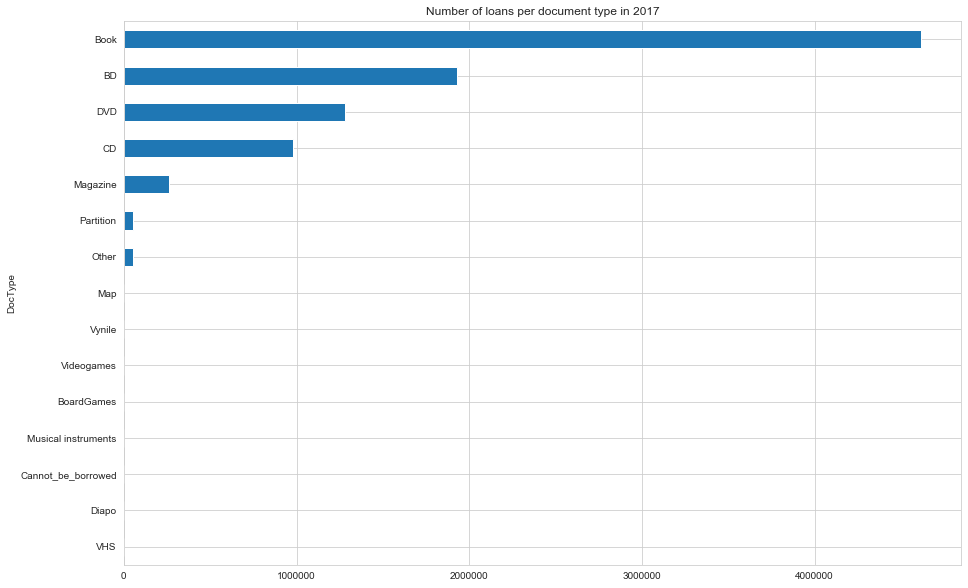

In [44]:
dataBook.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

plt.title('Number of loans per document type in 2017')

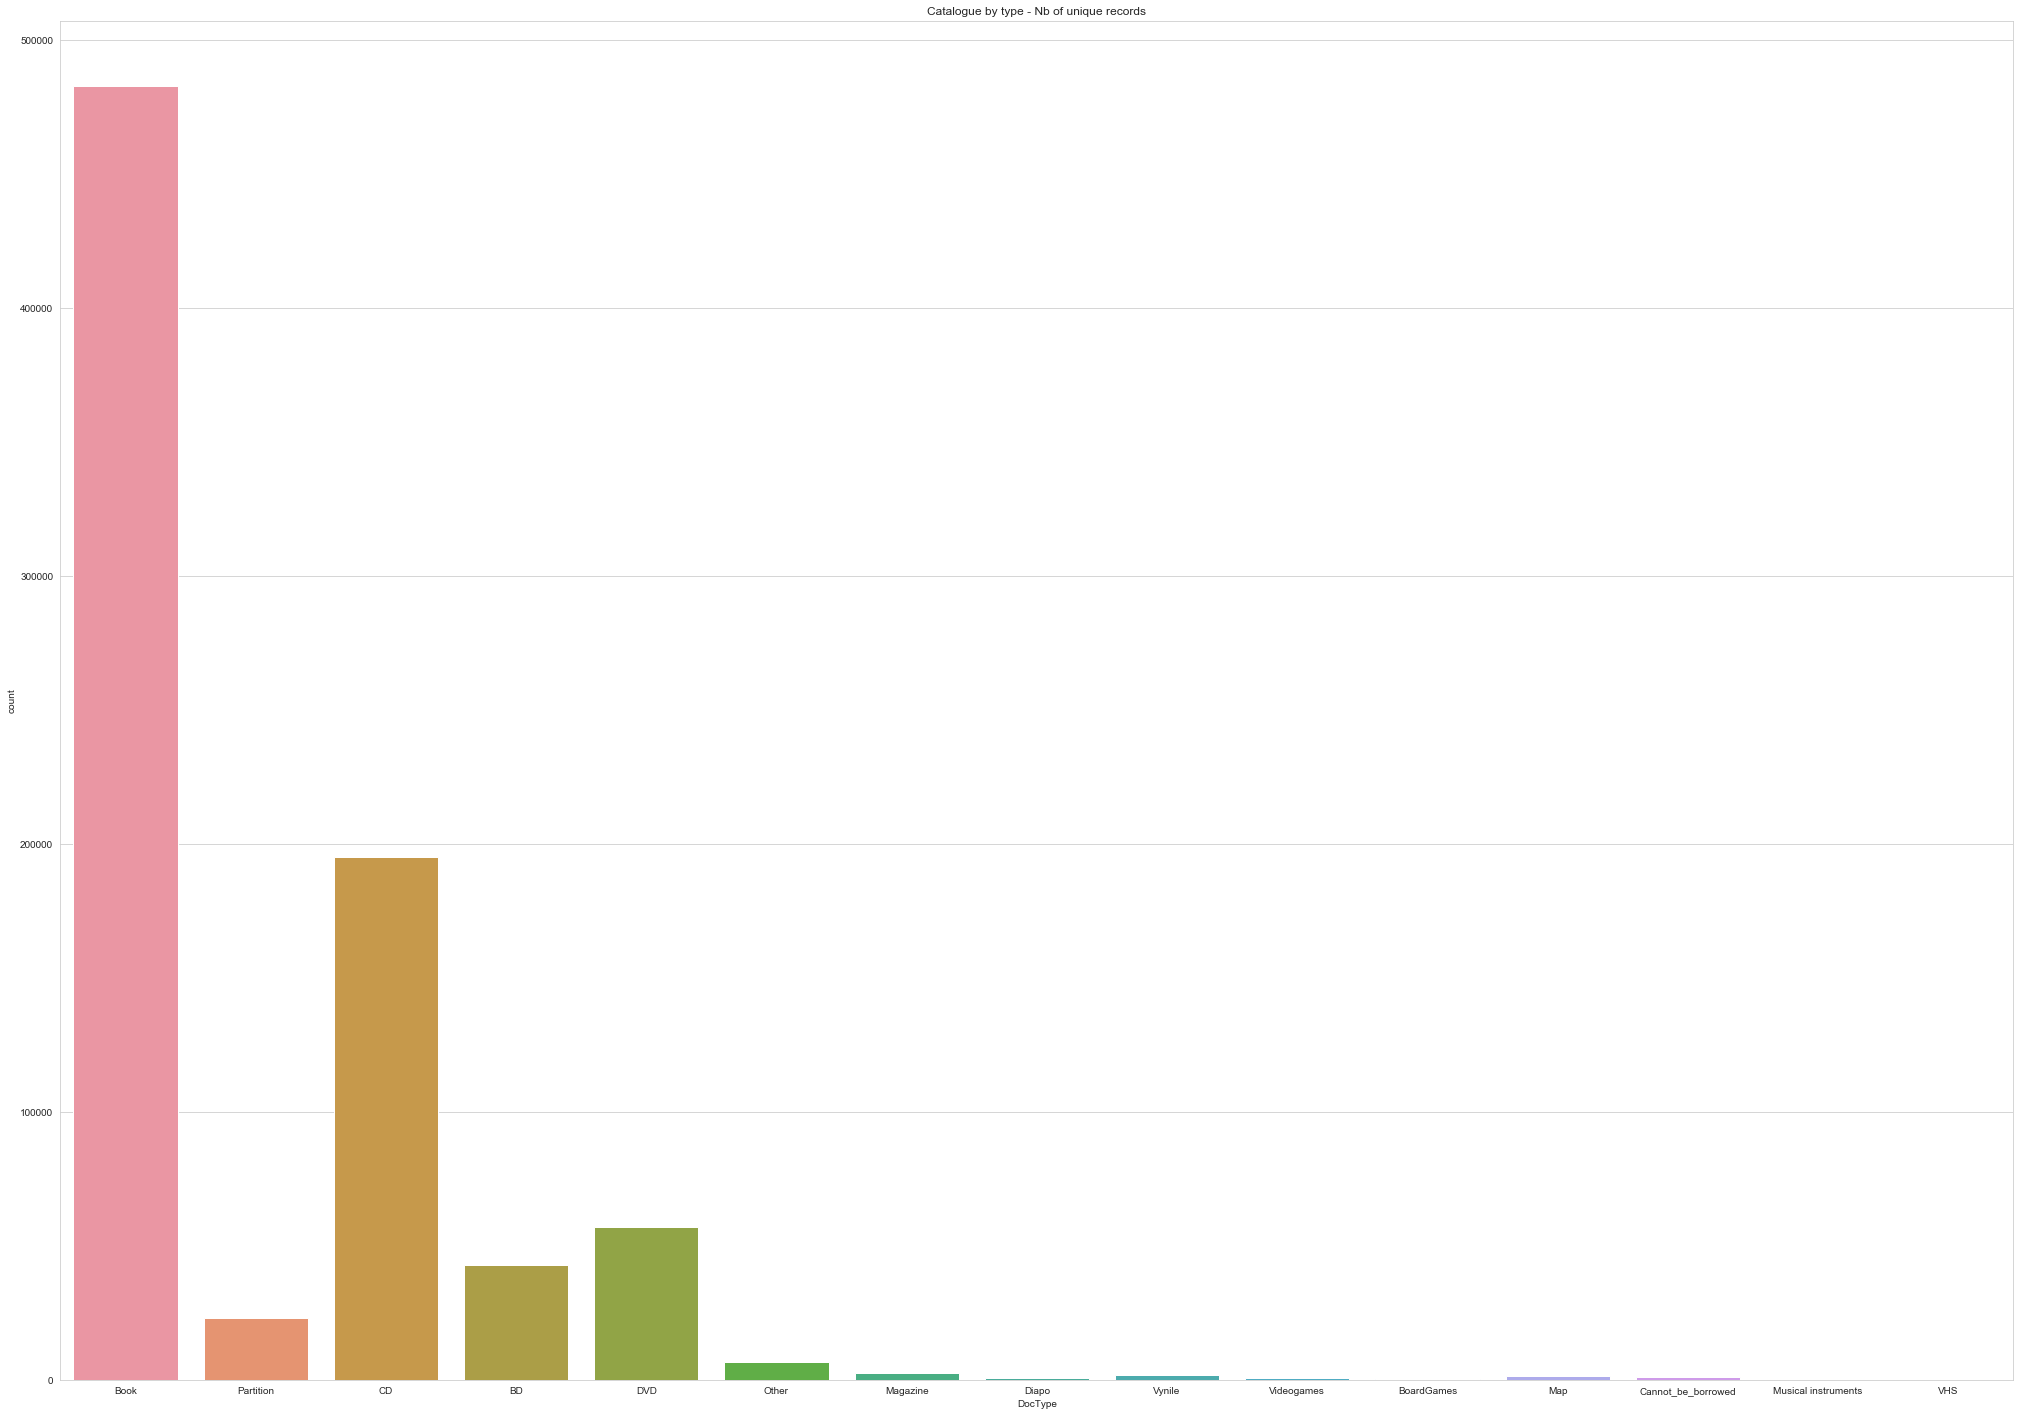

In [43]:
fig, ax = plt.subplots(figsize=(35,25))
sns.countplot(dataBook['DocType'])
plt.title('Catalogue by type - Nb of unique records')
plt.show()

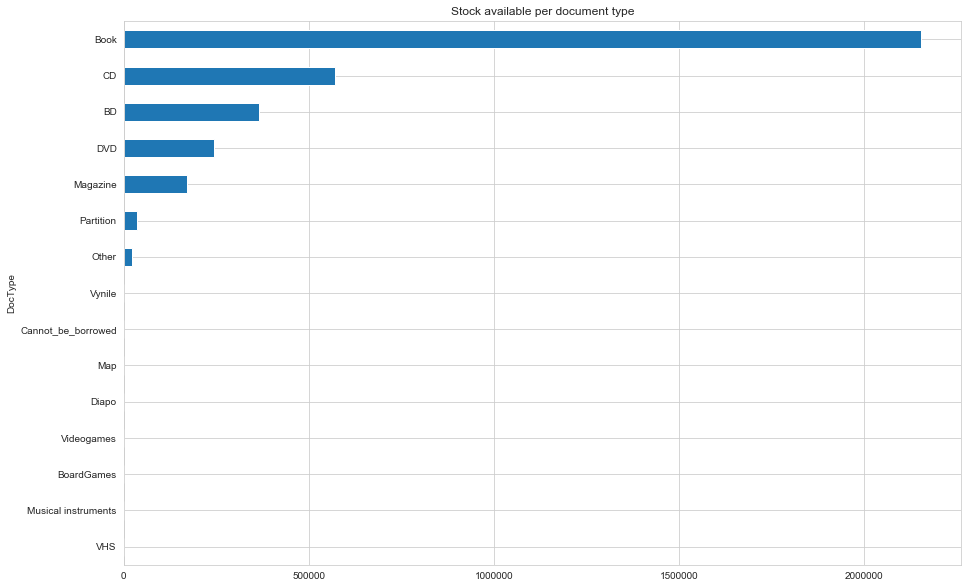

DocType
Book                   2152731.0
CD                      570734.0
BD                      363790.0
DVD                     242277.0
Magazine                169510.0
Partition                36064.0
Other                    23001.0
Vynile                    1659.0
Cannot_be_borrowed        1468.0
Map                       1356.0
Diapo                      923.0
Videogames                 739.0
BoardGames                 721.0
Musical instruments         25.0
VHS                          5.0
Name: Nombre_d'exemplaires, dtype: float64

In [45]:


# Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Stock available per document type')
plt.show()
dataBook.groupby('DocType')["Nombre_d'exemplaires"].agg('sum').sort_values(ascending=False)

# TO DO :Plot Number of loans by document type and  total number of document available('Nombre d'examplaires')


In [ ]:
# Plot Number of loans by document type and  total number loans

 

In [46]:
#Look at the different types/format of info in Date columns
# Date give us more or less the age of the book (printing, edition,)
dataBook['Date'].value_counts().to_dict()

{'2004': 25126,
 '2017': 24924,
 '2003': 23471,
 '2002': 21567,
 '2001': 19751,
 '2000': 18409,
 '2005': 18177,
 '1999': 17394,
 '2012': 17081,
 '2006': 17042,
 '2016': 16909,
 '2007': 16603,
 '1998': 16184,
 '2011': 15227,
 '1997': 14965,
 '2015': 14721,
 '2013': 14272,
 '2014': 14250,
 '2008': 14098,
 '1996': 13789,
 '1995': 13665,
 '1994': 13337,
 '2010': 13291,
 'DL 2015': 12616,
 '1992': 12588,
 '1990': 12172,
 '1993': 12131,
 '1991': 12121,
 '2009': 12069,
 '1989': 10732,
 'DL 2016': 9864,
 'impr. 2013': 9474,
 '1988': 9292,
 'impr. 2010': 9060,
 '1987': 8354,
 'impr. 2009': 8346,
 '2018': 8341,
 'impr. 2011': 8128,
 'impr. 2008': 8086,
 'impr. 2012': 7975,
 '1986': 7528,
 'impr. 2007': 7518,
 'DL 2014': 7309,
 'impr. 2014': 6990,
 'DL 2010': 6773,
 'DL 2013': 6557,
 'DL 2009': 6553,
 'DL 2008': 6486,
 'impr. 2006': 6247,
 '1985': 6196,
 'DL 2011': 6086,
 'DL 2012': 5732,
 'DL 2007': 5599,
 '1984': 5435,
 'impr. 2005': 4780,
 'DL 2006': 4719,
 '1983': 4490,
 '1982': 3976,
 'DL 20

In [47]:
dataBook['Date'].isna().sum()

4725

In [48]:
#fill missing date with na
dataBook['Date'].fillna('UnknownDate',inplace=True)

In [49]:
# Format of Date are pretty different. Some values are not complete or not data

#Action:correct date to Year only

#check if string contains a number
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

# find all date or date like (finding digit)
def findDate(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return x

def findDate2(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return 'Unknown'

def findDate3(x):
    if hasNumbers(x):
        return re.findall(r'\d+',x)
    else:
        return 'Unknown'

In [50]:
dataBook['DateAge']=dataBook['Date'].map(lambda x : findDate(x))

In [ ]:
dataBook['DateAge'].value_counts()

In [ ]:
dataBook['Langue'].isna().sum()

In [ ]:
dataBook['Langue'].value_counts()

In [ ]:
dataBook[dataBook['Langue'].isna()]

In [51]:
dataBook['Langue'].fillna('Unknown',inplace=True)


In [ ]:
dataBook['Langue'].value_counts()

In [80]:
dataBook.groupby('Langue')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

Langue
français                 False
Unknown                  False
anglais                  False
sans                     False
multilingue              False
                         ...  
gothique                  True
espéranto                 True
dakota                    True
couchitiques, langues     True
kpellé                    True
Name: Nombre_de_prêts_2017, Length: 219, dtype: bool

In [81]:
def GroupOther3(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [82]:
def GroupOther(col):
    selection=(dataBook[col].value_counts(normalize=True)*100).lt(0.5)
    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [83]:
#Create new columns Language
dataBook['Language']=dataBook['Langue']


In [84]:
dataBook['Language']=GroupOther3('Langue')


In [86]:
dataBook.Language=dataBook['Language'].str.replace('sans','Unknown')
dataBook.Language=dataBook['Language'].str.replace('Unknown','Other')
dataBook.Language=dataBook['Language'].str.replace('multilingue','Other')

In [87]:
dataBook['Language'].value_counts()

français    559709
Other       142327
anglais      90506
allemand      8338
italien       8165
espagnol      6486
Name: Language, dtype: int64

In [88]:
dataBook['Language'].isna().sum()

0

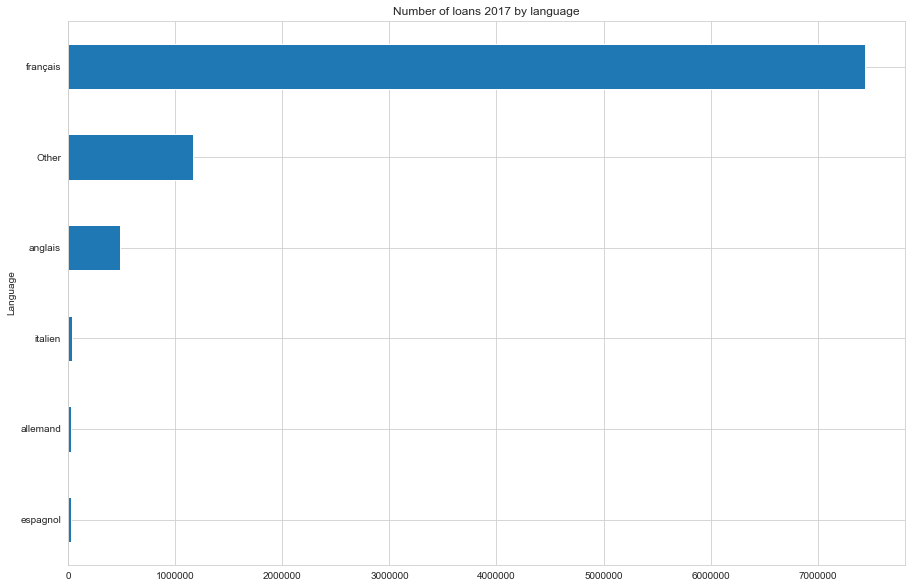

Language
français    7442654.0
Other       1163747.0
anglais      486925.0
italien       33535.0
allemand      26969.0
espagnol      26646.0
Name: Nombre_de_prêts_2017, dtype: float64

In [90]:

# Plot Number of loans by language
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))
plt.title('Number of loans 2017 by language')
plt.show()
dataBook.groupby('Language')["Nombre_de_prêts_2017"].agg('sum').sort_values(ascending=False)



In [ ]:
#dataBook['Edition'].value_counts()

In [91]:
to_drop.append('Edition')

In [92]:
dataBook['Editeur'].isna().sum()

0

In [93]:
dataBook['Editeur'].value_counts()

Gallimard                                           26397
Flammarion                                          11152
Presses universitaires de France                     6061
A. Michel                                            5763
Fayard                                               5720
                                                    ...  
Zhongguo hai guan, impr.                                1
Disques Pierre Vérany                                   1
Activision;Activision Blizzard France [distrib.]        1
Philipp Reclam jun.                                     1
False Idols/!K7                                         1
Name: Editeur, Length: 89451, dtype: int64

In [77]:
dataBook['Editeur'].unique()

array(["Documentation française ;Ministère des affaires étrangères, Direction de la presse, de l'information et de la communication",
       'Diderot éditeur, arts et sciences', 'Plon', ..., 'Éd. Solilang',
       'rough Trade', 'Makafresh'], dtype=object)

In [94]:
dataBook['Editeur'].fillna('Unknown',inplace=True)

In [96]:
#dataBook.groupby('Editeur')['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(0.25)



In [97]:
#selectop, depending on count of records
dataBook['Publisher']=dataBook['Editeur']
dataBook['Publisher']=GroupOther('Editeur')
    

In [98]:
dataBook.Publisher.value_counts()

Other                               714302
Gallimard                            26397
Flammarion                           11152
Presses universitaires de France      6061
A. Michel                             5763
Fayard                                5720
Éd. du Seuil                          5130
Unknown                               5012
Hachette                              4703
Nathan                                4577
Casterman                             4526
R. Laffont                            4524
Pocket                                4484
Glénat                                4455
Librairie générale française          4437
Actes Sud                             4288
Name: Publisher, dtype: int64

In [99]:
dataBook['Format'].value_counts()

1 disque compact | 1 brochure                                                                       23583
1 disque compact | DDD | 1 brochure                                                                 21253
1 compact | 1 brochure                                                                              20918
1 compact | DDD | 1 brochure                                                                        13159
1 compact | 1 dépliant                                                                               8168
                                                                                                    ...  
1 vol. (143 p.) | ill. en noir et en coul., couv. ill. en coul. | 23 x 29 cm                            1
1 disque compact (40 min 20 s) | 1 brochure ([12] p.) : ill. en coul. ; 12 cm                           1
1 DVD vidéo  | coul, son.                                                                               1
63 p. | ill. en noir et en coul., cartes | 30 

In [100]:
to_drop.append('Format')

In [102]:
dataBook['Collection'].value_counts().head(10)

Du monde entier             1562
Roman                        910
Pour les nuls                697
Grands détectives            674
Bouquins                     615
Littérature étrangère        570
Le routard                   545
10-18 | Domaine étranger     530
Neuf                         496
Médium                       487
Name: Collection, dtype: int64

In [103]:
dataBook['Collection'].isna().sum()
dataBook['Collection']=dataBook['Collection'].fillna('Unknown')

In [104]:
dataBook['New_Collection']=dataBook['Collection']
dataBook['New_Collection']=np.where(dataBook['Collection'].isin(dataBook['Collection'].value_counts().head(15).index) ,dataBook['Collection'],'Other')

In [ ]:
dataBook['New_Collection'].value_counts()

In [ ]:
dataBook['Titre_de_série'].value_counts()

In [105]:
to_drop.extend(['Titre_de_série','N°','Dates','EAN','ISSN','New_Collection','Collection','Cote_majoritaire'])

In [ ]:
dataBook.shape

In [ ]:
to_drop

In [106]:
df=dataBook.drop(columns=to_drop)


In [ ]:
df

In [107]:
dataBook.shape, df.shape

((815531, 111), (815531, 81))

In [ ]:
#Reduce scope of study to Books, BD

In [ ]:
#df1=df.drop(dataBook.iloc[:,38:97],axis=1)

In [ ]:
#df1.shape

In [ ]:
#df1.head()

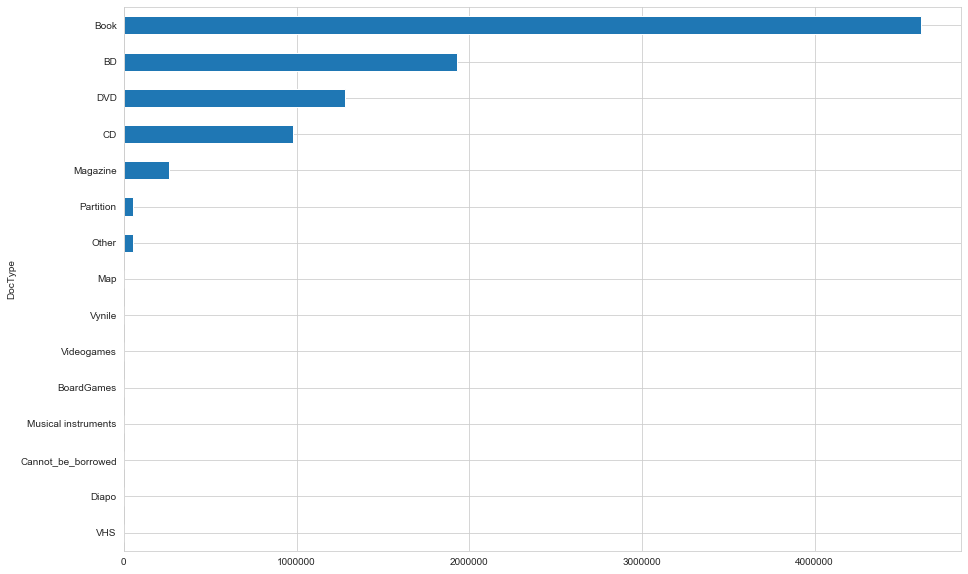

In [108]:
df.groupby('DocType')['Nombre_de_prêts_2017'].agg('sum').sort_values(ascending=True).plot(kind='barh',figsize=(15,10))

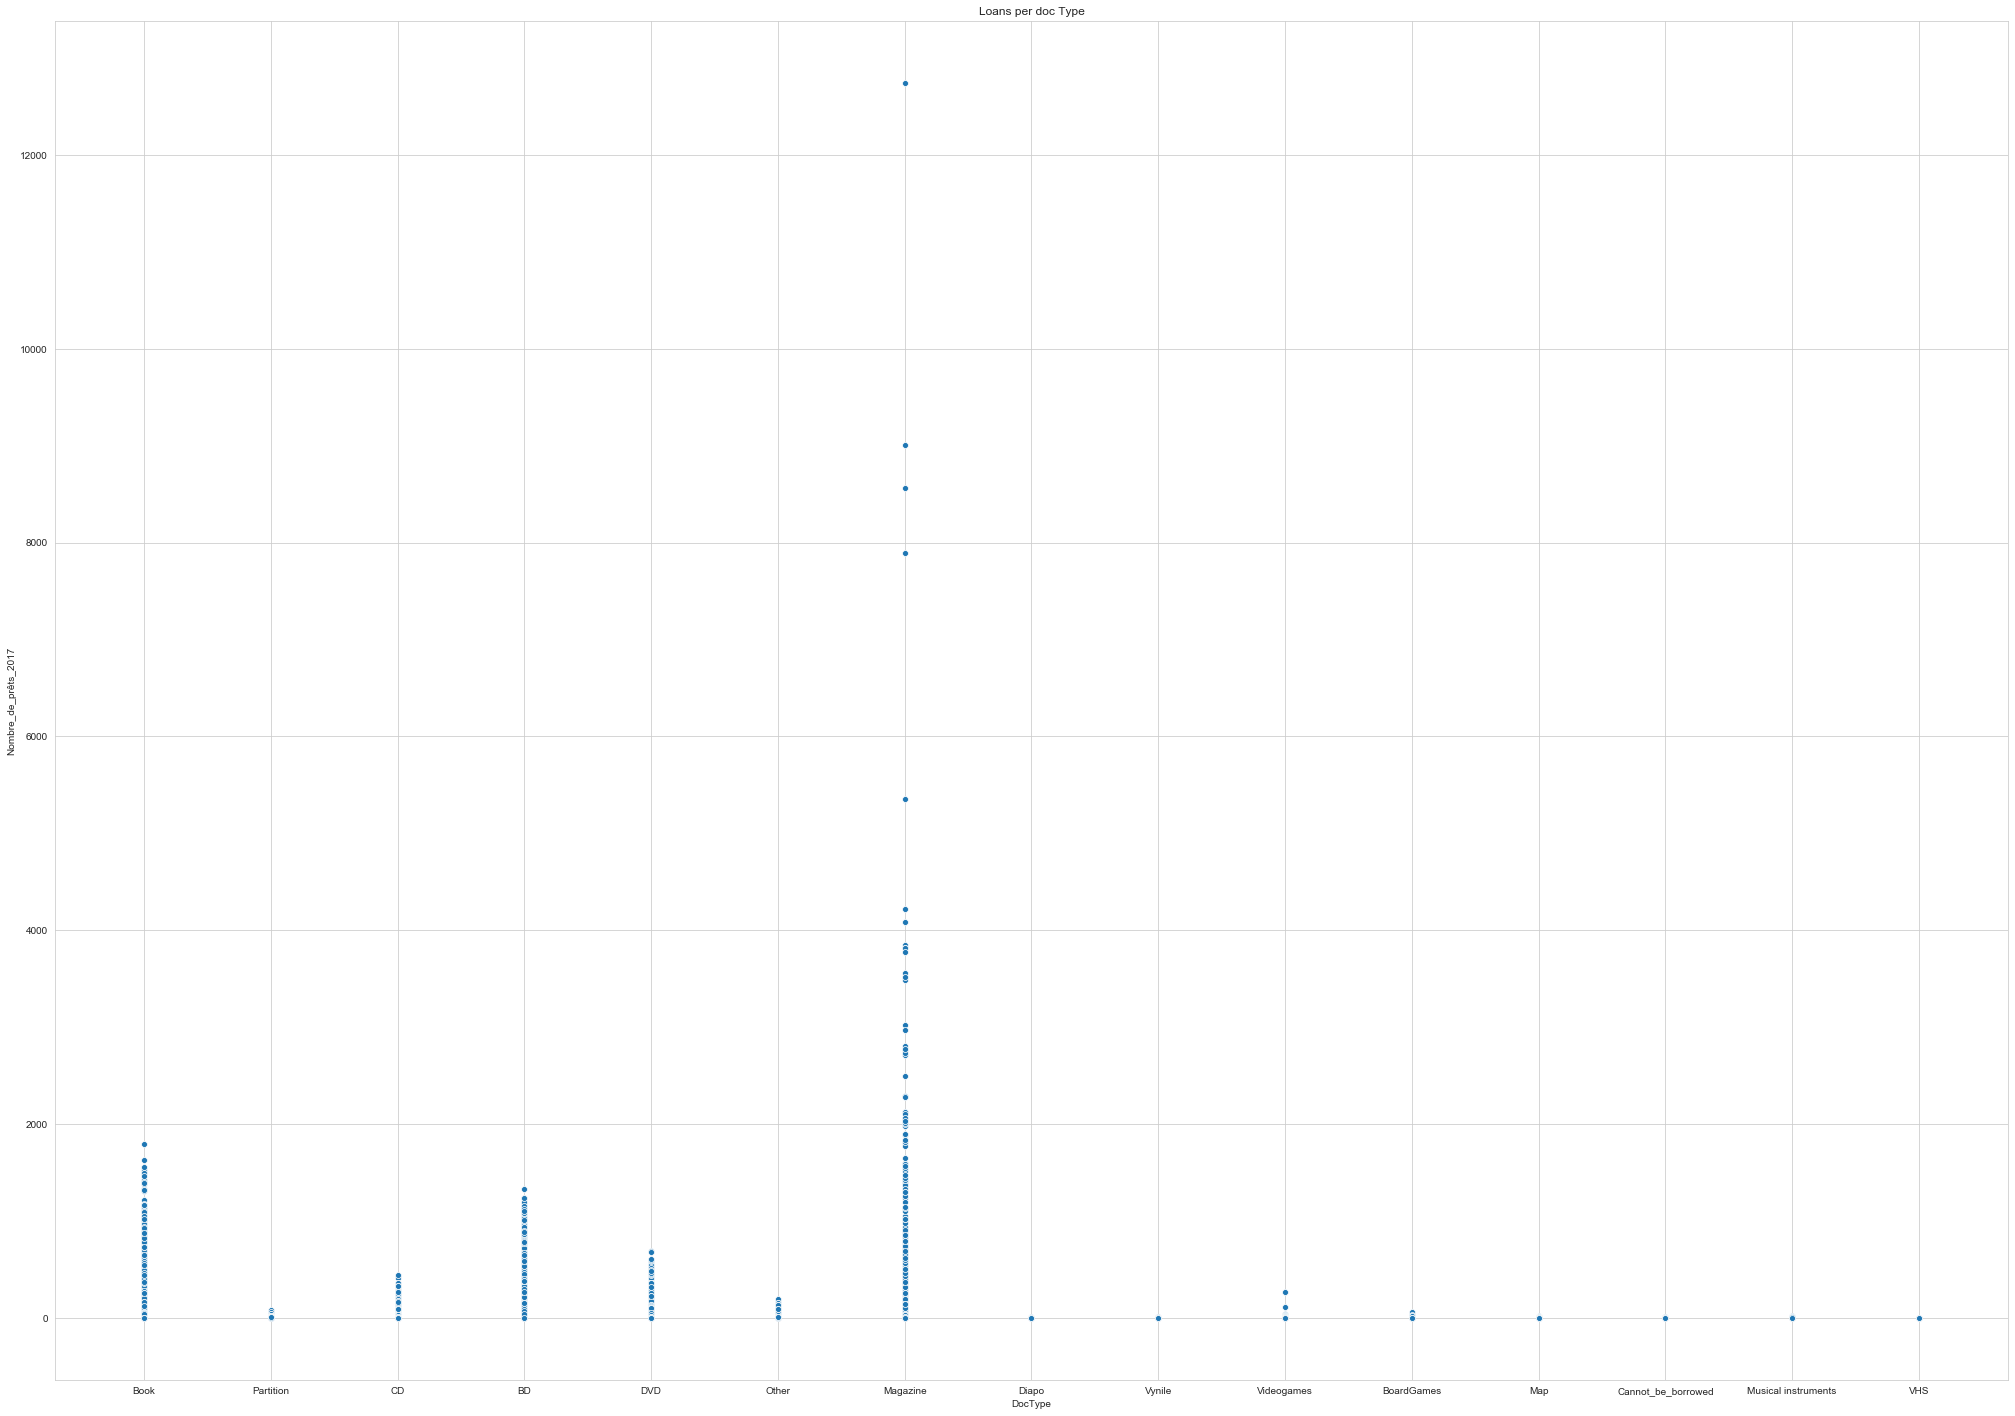

In [110]:
fig, ax = plt.subplots(figsize=(35,25))
sns.scatterplot(df.DocType,df['Nombre_de_prêts_2017'])
plt.title('Loans per doc Type')
plt.show()

In [111]:
df[df.DocType=='Magazine']['Nombre_de_prêts_2017'].max()

12745.0

In [112]:
#magazine le plus emprunté
df[(df.DocType=='Magazine')&(df['Nombre_de_prêts_2017']==12745.0)]

,N°_de_notice,ISBN,Langue,Titre,Editeur,Date,Type_de_document,Nombre_de_localisations,Nombre_de_prêt_total,Nombre_de_prêts_2017,...,Vandamme,Vaugirard,Co-auteur,Author,Author_secondary,Co_Author,DocType,DateAge,Language,Publisher
703815,676189,NaN,français,J'aime lire,Bayard-Presse,1976-,Revue jeunesse,54.0,48009,12745,...,22.0,36.0,NaN,UnknownAuthor,UnknownAuthor,UnknownAuthor,Magazine,[1976],français,Other


In [115]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]

703815    2365
Name: Nombre_d'exemplaires, dtype: object

In [116]:
df[(df.Titre=="J'aime lire")]["Nombre_d'exemplaires"]/54

703815    43.7963
Name: Nombre_d'exemplaires, dtype: object

In [117]:
df['DateAge']=df['Date'].map(lambda x : findDate2(x))

In [118]:
df['DateAge']=df.DateAge.astype(str).str.replace('[','').str.replace(']','').str.replace("'",'')

In [119]:
df['DateAge']

0         2003
1         1998
2         1977
3         1997
4         1984
          ... 
815529    2008
815530    2007
815531    2005
815532    2008
815533    2009
Name: DateAge, Length: 815531, dtype: object

In [120]:
list(df.DateAge.value_counts().index)

['2013',
 '2012',
 '2007',
 '2010',
 '2008',
 '2011',
 '2014',
 '2009',
 '2006',
 '2015',
 '2005',
 '2016',
 '2004',
 '2017',
 '2003',
 '2002',
 '2001',
 '2000',
 '1999',
 '1998',
 '1997',
 '1996',
 '1995',
 '1994',
 '1992',
 '1990',
 '1993',
 '1991',
 '1989',
 '1988',
 '1987',
 '2018',
 '1986',
 'Unknown',
 '1985',
 '1984',
 '1983',
 '1982',
 '1980',
 '1981',
 '1979',
 '1978',
 '1977',
 '1976',
 '1975',
 '1973',
 '1974',
 '1972',
 '1971',
 '1970',
 '1969',
 '1968',
 '1967',
 '1966',
 '19',
 '1965',
 '1964',
 '1963',
 '1961',
 '1962',
 '1960',
 '1959',
 '1958',
 '1957',
 '1956',
 '1955',
 '1954',
 '199',
 '1951',
 '1947',
 '1952',
 '1953',
 '1950',
 '1948',
 '1949',
 '198',
 '1946',
 '200',
 '1925',
 '1931',
 '1930',
 '1927',
 '1929',
 '2017, 2017',
 '1945',
 '1934',
 '1937',
 '1932',
 '1938',
 '1928',
 '1926',
 '1935',
 '2009, 2009',
 '2016, 2016',
 '1936',
 '2013, 2013',
 '1933',
 '2011, 2011',
 '2012, 2012',
 '1942',
 '1924',
 '1939',
 '2014, 2014',
 '1941',
 '1923',
 '1943',
 '1921

In [ ]:
df.head()

In [121]:
df.isna().sum()

N°_de_notice         0
ISBN            323242
Langue               0
Titre                0
Editeur              0
                 ...  
Co_Author            0
DocType              0
DateAge              0
Language             0
Publisher            0
Length: 81, dtype: int64

In [123]:
df.Nombre_de_localisations=df.Nombre_de_localisations.astype('int')

In [124]:
# Dummies
df.Language.unique()

array(['français', 'anglais', 'Other', 'allemand', 'espagnol', 'italien'],
      dtype=object)

In [125]:
Dummies_NA.append('Language')

In [126]:
df.Nombre_de_prêts_2017=df.Nombre_de_prêts_2017.astype('int')

In [131]:
df.Catégorie_statistique_1.value_counts()

LFRA Litterature francaise          92818
LNAM Litterature nord-americaine    32876
LBDE Bandes dessinees               29498
LALB Albums                         28094
LBRI Litterature britannique        25858
                                    ...  
240                                     1
249                                     1
Vie pratique sauf cuisine               1
Cuisine, alimentation                   1
Sport                                   1
Name: Catégorie_statistique_1, Length: 342, dtype: int64

In [136]:
def GroupOther4(col):
    
    selection=dataBook.groupby(col)['Nombre_de_prêts_2017'].agg('sum').map(lambda x : x*100/dataBook['Nombre_de_prêts_2017'].sum()).sort_values(ascending=False).lt(1)

    return np.where(dataBook[col].isin(selection[selection==True].index) ,'Other',dataBook[col])

In [137]:
df['Categories_stat']=df.Catégorie_statistique_1

In [138]:
df['Categories_stat']=GroupOther4('Catégorie_statistique_1')

In [139]:
df['Categories_stat'].value_counts()

Other                               554617
LFRA Litterature francaise           92818
LNAM Litterature nord-americaine     32876
LBDE Bandes dessinees                29498
LALB Albums                          28094
LBRI Litterature britannique         25858
CNAM Cinema nord-americain           16831
D911 Guides de voyage, tourisme      12926
LMAN Mangas                          11823
CFRA Cinema francais                 10190
Name: Categories_stat, dtype: int64

In [140]:
Dummies_NA.append('Categories_stat')

In [141]:
df.DocType.unique()

array(['Book', 'Partition', 'CD', 'BD', 'DVD', 'Other', 'Magazine',
       'Diapo', 'Vynile', 'Videogames', 'BoardGames', 'Map',
       'Cannot_be_borrowed', 'Musical instruments', 'VHS'], dtype=object)

In [142]:
Dummies_NA.append('DocType')

In [143]:
df.Publisher.unique()

array(['Other', 'Presses universitaires de France', 'Fayard', 'Hachette',
       'Unknown', 'Gallimard', 'Librairie générale française', 'Nathan',
       'Éd. du Seuil', 'Flammarion', 'Actes Sud', 'Casterman', 'Pocket',
       'R. Laffont', 'Glénat', 'A. Michel'], dtype=object)

In [144]:
Dummies_NA.append('Publisher')

In [145]:
Dummies_NA

['Language', 'Categories_stat', 'DocType', 'Publisher']

In [146]:
df.columns

Index(['N°_de_notice', 'ISBN', 'Langue', 'Titre', 'Editeur', 'Date',
       'Type_de_document', 'Nombre_de_localisations', 'Nombre_de_prêt_total',
       'Nombre_de_prêts_2017', 'Nombre_de_prêt_année_2018_au_26_juillet_2018',
       'Nombre_d'exemplaires', 'Catégorie_statistique_1',
       'Catégorie_statistique_2', 'Aimé_Césaire', 'Amélie', 'André_Malraux',
       'Andrée_Chedid', 'Arthur_Rimbaud', 'Assia_Djebar', 'Batignolles',
       'Benjamin_Rabier', 'Buffon', 'Canopée_-_la_fontaine', 'Chaptal',
       'Charlotte_Delbo', 'Claude_Lévi-Strauss', 'Colette_Vivier',
       'Courcelles', 'Couronnes_-_Naguib_Mahfouz', 'Crimée', 'Diderot',
       'Drouot', 'Edmond_Rostand', 'Europe', 'Faidherbe', 'Fessart',
       'François_Villon', 'Françoise_Sagan', 'Georges_Brassens',
       'Germaine_Tillion', 'Glacière', 'Goutte_d'Or', 'Gutenberg',
       'Hélène_Berr', 'Hergé', 'Heure_Joyeuse', 'Italie',
       'Jacqueline_de_Romilly', 'Jean-Pierre_Melville', 'Lancry',
       'Louise_Michel', 'Margu

In [156]:
df1=df[['Language','Publisher','Categories_stat','DocType','Nombre_de_localisations',"Nombre_d'exemplaires",'Nombre_de_prêts_2017']]

In [157]:
df1.shape

(815531, 7)

In [154]:
df2=pd.get_dummies(data=df1, columns=Dummies_NA)

In [155]:
df2

,Nombre_de_localisations,Nombre_d'exemplaires,Language_Other,Language_allemand,Language_anglais,Language_espagnol,Language_français,Language_italien,Categories_stat_CFRA Cinema francais,Categories_stat_CNAM Cinema nord-americain,...,Publisher_Glénat,Publisher_Hachette,Publisher_Librairie générale française,Publisher_Nathan,Publisher_Other,Publisher_Pocket,Publisher_Presses universitaires de France,Publisher_R. Laffont,Publisher_Unknown,Publisher_Éd. du Seuil
0,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,2,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,3,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815529,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815530,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815531,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
815532,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Modelling

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import add_constant

In [ ]:
from statsmodels.api import OLS

In [ ]:
Y=df.Nombre_de_prêts_2017